# Lab 6: Convolutional Network Architectures
## by Michael Doherty, Leilani Guzman, and Carson Pittman

Imagine life in Florence, Italy in the early 1500s. The Renaissance is at its peak, the Catholic Church is abusing its power, and the plebians cried themselves to sleep every night knowing they [probably wouldn't live past 40](https://www.verywellhealth.com/longevity-throughout-history-2224054). And then there was Leonardo da Vinci, who decided [to create a self-propelled car "for theatrical use"](https://www.da-vinci-inventions.com/self-propelled-cart). While da Vinci was ahead of his time, his work would later inspire others to create the first self-driving car.

Our dataset, titled "Vehicle Detection Image Set", is a dataset of 64x64 images, with each image being classified as either <code>vehicle</code> or <code>non-vehicle</code>. Our task is to create a Convolutional Neural Network that can classify images as being either <code>vehicle</code> or <code>non-vehicle</code>.

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 1. Preparation
### 1.1 Performance Metric

We'll start by reading in the data from our vehicle detection Kaggle dataset.

There are 17760 images


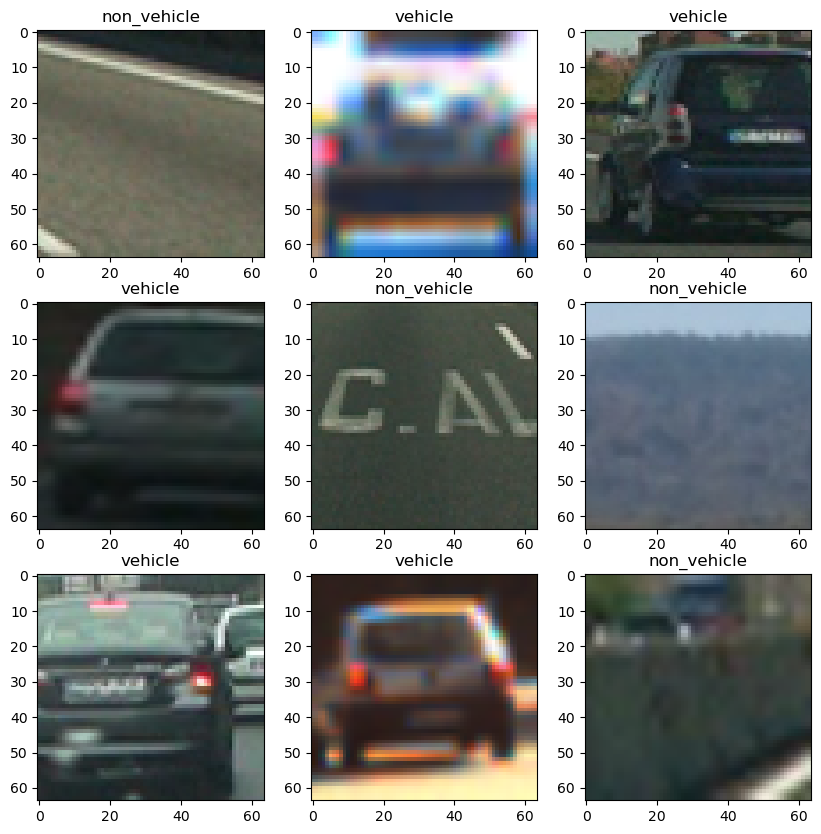

In [1]:
import glob
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

warnings.simplefilter('ignore')

# load in images and labels as numpy arrays
images_and_labels = []

#FIXME just make 2 separate lists later, make labels 0/1 by default??
# FIXME should we make images grayscale??

for filename in glob.glob('data/vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'vehicle')))
    

for filename in glob.glob('data/non-vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'non_vehicle')))
    

print('There are', len(images_and_labels), 'images')

# plot some images
plt.figure(figsize = (10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(0, len(images_and_labels))
    plt.imshow(images_and_labels[index][0].astype('uint8'))
    plt.title(images_and_labels[index][1])

It's important to note that these images seem to have been sourced by splitting an image, taken from a car driving on a road, into multiple sub-images that are all 64x64 pixels (as shown in the example images above). This is relevant, as it means all images in this dataset are things a car could realistically see while driving.

Now that we've read in the images, let's visualize the distribution of labels for our images.

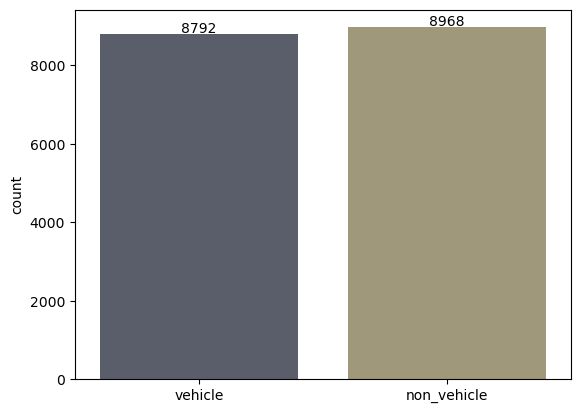

In [4]:
import seaborn as sns

ax = sns.countplot(x=[label for _, label in images_and_labels], palette='cividis')

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.xticks([0,1], ['vehicle', 'non_vehicle'])
plt.show()

As we can see, there are about the same number of instances for each label (<code>non_vehicle</code> has a little less than 200 more instances than <code>vehicle</code>). Because the number of images in both of our classes are so similar, there will be negligible effects from class imbalance. Thus, we will utilize **accuracy** as our evaluation metric.

Despite accuracy being flawed in many situations, it actually fits our needs for this dataset. In balanced datasets, accuracy favors all classes equally, which in our case is needed, as we would want our self-driving cars to avoid both other vehicles as well as other road hazards. Accuracy also cares about all errors equally, which is needed, as swerving to avoid a car that is not there (false positives) and colliding with cars the system did not detect (false negatives) are both undesirable outcomes. Finally, as we noted earlier, all of the images in this dataset come from actual image data captured by cars driving on roads; thus, all of the image data is relevant, and we want our model to be able to distinguish between vehicles and anything else it may see while driving on a road.

For these reasons, we will use accuracy to determine the performance of our neural networks. Because of our business case, we believe our prediction models would need to be more than 99% accurate to be considered usable in a real world self-driving car (as incorrect predictions could potentially result in loss of human life).

### 1.2 Training and Testing Method
Now we'll split our dataset into training and testing splits. We are not stratifying our splits because both of are classes basically have the same number of images so randomly selecting will give us a balanced subset of images. We also normalize the pixel values and shift the mean to be zero, to remove as much noise as possible for the models.

In [36]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

cv = KFold(n_splits=5, shuffle=True, random_state=1)

X = np.array([image for image, _ in images_and_labels])
y = np.array([0 if label == 'vehicle' else 1 for _, label in images_and_labels])

# normalize pixel values and mean shift
X = X/255.0 - 0.5

def get_accuracy(X, y, new_model):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    accuracies = []

    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index, :, :, :], X[test_index, :, :, :]
        y_train, y_test = y[train_index], y[test_index]

        history = new_model.fit(X_train, y_train, batch_size=64,
                                epochs=5, verbose=0,
                                validation_data=(X_test,y_test),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

        loss, stats = new_model.evaluate(X_test, y_test, verbose=0)

        # print('Fold', i)
        # print(f'Accuracy: {history.history["val_accuracy"][-1]:.3f}')
        # print(f'Loss: {loss:.3f}')
        i += 1
        
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='training')

        plt.ylabel('Accuracy %')
        plt.title('Training')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='training')
        plt.ylabel('Training Loss')
        plt.xlabel('epochs')

        plt.plot(history.history['val_loss'], label='validation')
        plt.xlabel('epochs')
        plt.title('Loss')
        plt.legend()
        plt.show()

        accuracies.append(history.history['val_accuracy'][-1])

    plt.bar(range(len(accuracies)), accuracies)
    plt.ylim([min(accuracies) - 0.01, max(accuracies)])
    plt.title('Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    print("Average Accuracy:", np.mean(accuracies))
    
    return accuracies


As seen above, we decided to...

## 2. Modeling
### 2.1 Data Augmentation
Now that we've defined our performance metric and created training and testing splits for cross validation, let's start creating our Convolutional Neural Networks! Let's start by creating a base for our models that includes some data augmentation layers.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness

model_base = Sequential()

model_base.add(RandomFlip("horizontal"))
model_base.add(RandomRotation(0.2))
model_base.add(RandomZoom((-0.1, 0.1)))
model_base.add(RandomBrightness(0.2))

For our Convolutional Neural Networks, we decided to use the following data augmentation layers:
- <code>RandomFlip("horizontal")</code>: This layer will randomly flip some of the images horizontally (i.e., what's on the left side of the image would now be on the right side of the image). This is appropriate, as self-driving cars would likely encounter vehicles and non-vehicles with different horizontal alignments (such as cars angled slightly right OR slightly left, roads angled slightly right OR slightly left, etc.).
- <code>RandomRotation(0.2)</code>: This layer will randomly rotate an image by up to 20%. This is appropriate, as self-driving cars would likely encounter vehicles and non-vehicles with different orientations (such as cars angled slightly right/left/up/down (for curves in the road or going up hills), roads angled slightly right/left/up/down, etc.).
- <code>RandomZoom((-0.1, 0.1))</code>: This layer will randomly zoom in/out on an image by up to 10%. This is appropriate, as self-driving cars would encounter vehicles and non-vehicles at different distances (such as being close to some vehicles and far from others, close to some trees on the side of the road and far from others, etc.).
- <code>RandomBrightness(0.2)</code>: This layer will randomly increase/decrease the brightness of an image by up to 20%. This is appropriate, as self-driving cars would encounter vehicles and non-vehicles at different times of day with differing amounts of light (such as driving when it's dark very late at night or driving in the afternoon when there is a lot of sunlight).

We chose these augmentation layers because we believe that these slight rotations, zooms, and brightness changes will simulate what a self-driving car is going to see on the roads. We did not include vertical flips, and large augmentations as these will not be useful for our model to learn as they likely do not appear in the real world.

Now that we have our base, let's create a few different Convolutional Neural Networks.

**Dr. Larson said these Augmentation layers should be used for all of our models (i.e., we shouldn't change them after we initialize them, as it will make comparing models weird)**

**Dr. Larson also said that the 2 big augmentations we don't want to do are RandomFlip("vertical") and randomly rotating by too high a percentage (as even after augmentation, the images should still be something a car could realistically see while driving around on the road, and upside down or sideways cars would not be something the car would see)**

**Justification would be something like: A little bit of random rotation, as cars might be driving up a hill, changing brightness, as cars could be driving at different times of day with different lighting, etc.**

### 2.2 Model Creation
Now let's create a few different models using the base structure we just created.

#### 2.2.1 CNN 1: Basic Network
To start we will try a network like AlexNet to see how it performs on our data.

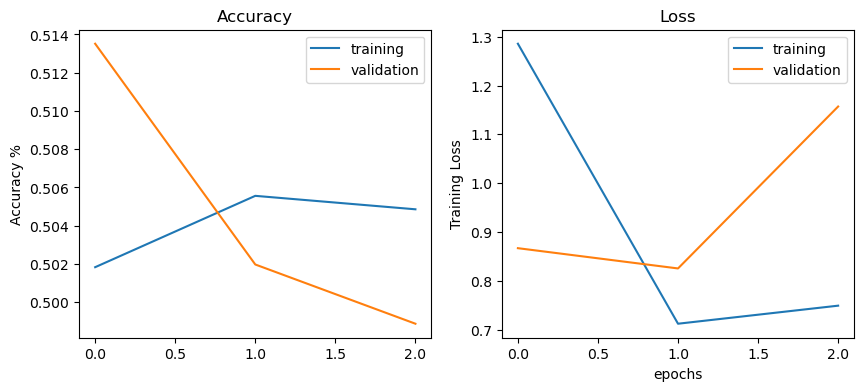

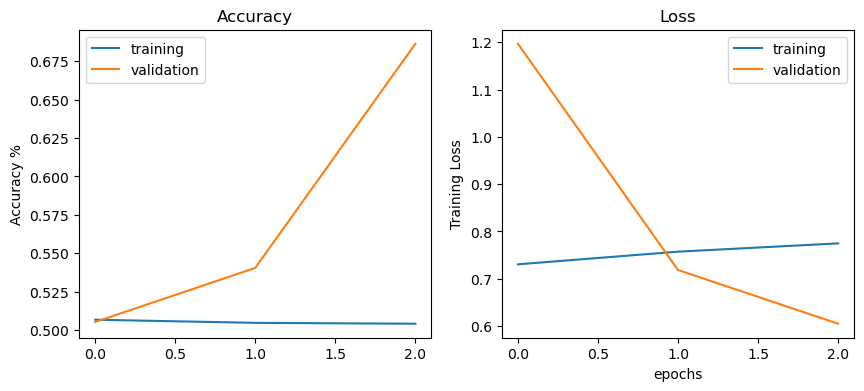

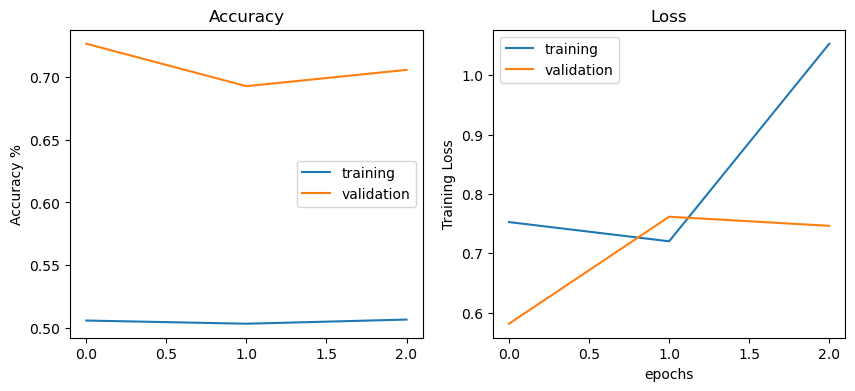

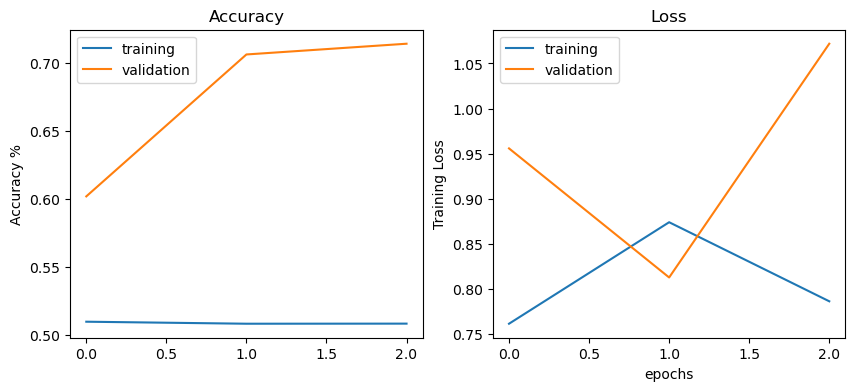

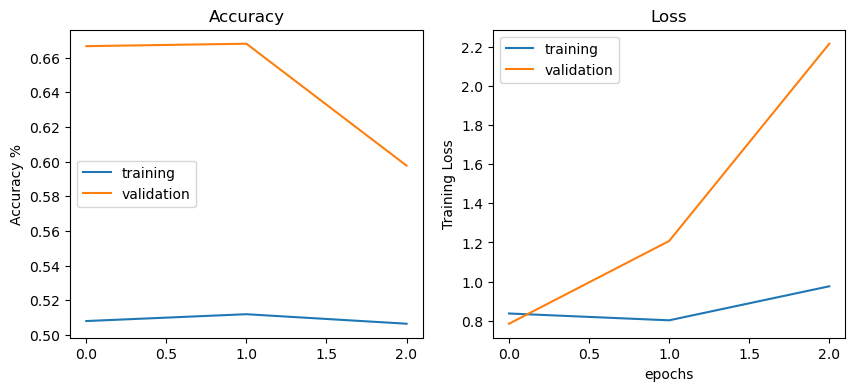

Average Accuracy: 0.640484231710434


[0.49887385964393616,
 0.6863738894462585,
 0.7055180072784424,
 0.7139639854431152,
 0.5976914167404175]

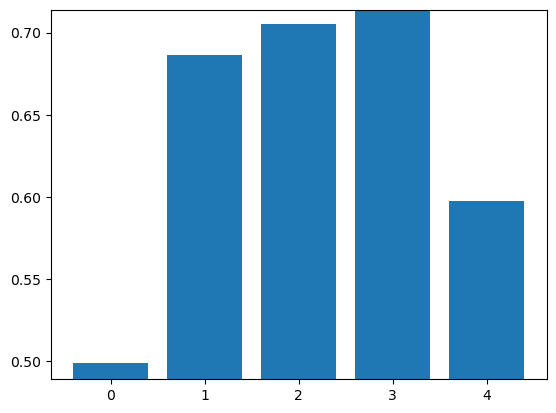

In [35]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_1 = clone_model(model_base)


# The following was copied from Dr. Larson's Notebook (12. More Advanced CNN Techniques)
NUM_CLASSES = 2
img_wh = 64

# let's start with an AlexNet style convolutional phase
cnn_1.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn_1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn_1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn_1.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn_1.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# history_1 = cnn_1.fit(X_train, y_train, batch_size=32, 
#                    epochs=5, verbose=1,
#                    validation_data=(X_test,y_test)
#                   )
accuracies_basic = get_accuracy(X, y, cnn_1)

Now let's plot the accuracy and training loss for this model.

**Might be able to get rid of all the warnings by upgrading Tensorflow version**

With these graphs of our model's performance, we can see that this model does not do better than just guessing on the training data. For the validation data, the accuracy is not consistent for the different epochs ****EDIT FOR FINAL RUN****

#### 2.2.2 CNN 2: Ensemble Network

Now, we will construct an Ensemble Network to increase our model’s accuracy. Ensemble Networks run multiple models and use the results from each one to increase performance and reduce overfitting. We also added max pooling to this model to take advantage of dimensionality reduction and down sampling to make the model faster while also disregarding redundant or not important features. This model also uses flattening and dropout like our previous model.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_30[0][0]']              
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_31[0][0]']              
 )                                                                                            

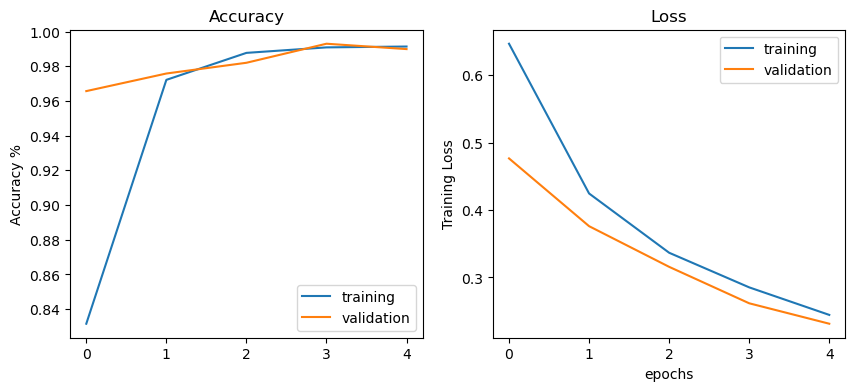

KeyboardInterrupt: 

In [37]:
%%time

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

num_ensembles = 3
l2_lambda = 0.0001 # notebook was 0.000001

input_holder = Input(shape=(img_wh,img_wh,3))


# Start with a convolutional layer
x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

branches = []
for _ in range(num_ensembles):
    # Start using NiN (MLPConv)
    x = Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(input_conv)
    
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='relu', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    x = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    # Add layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # Add dropout for regularization after convolution layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    x = Dense(NUM_CLASSES,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    # Now add this branch to the master list
    branches.append(x)

x = concatenate(branches)

x = Dense(1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l2(l2_lambda))(x)

# Setting the network using functional API
cnn_ens = clone_model(model_base)
cnn_ens = Model(inputs=input_holder, outputs=x)
cnn_ens.summary()

cnn_ens.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam',
                metrics=['accuracy'])

# ens_history = cnn_ens.fit(X_train, y_train, batch_size=32,
#                         steps_per_epoch=int(len(X_train)/128), 
#                         epochs=5, verbose=0,
#                         validation_data=(X_test,y_test),
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
#                         )

accuracies_ens = get_accuracy(X, y, cnn_ens)

Now lets create another CNN based on this Ensemble Network architecture, but with some modifications of the parameters. 


#### 2.2.3 CNN 3: Modified Ensemble Network

In [14]:
%%time
# MODIFIED ENSEMBLE MODEL
# Change the number of ensembles to 2 and the size of the kernels to 4x4

num_ensembles = 4 # was 3
l2_lambda = 0.0001 # notebook was 0.000001

input_holder = Input(shape=(img_wh,img_wh,3))


# Start with a convolutional layer
x = Conv2D(filters=32,
            kernel_size=((3,3)),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = Conv2D(filters=32,
            kernel_size=((3,3)),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

branches = []
for _ in range(num_ensembles):
    # Start using NiN (MLPConv)
    x = Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=((3,3)),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(input_conv)
    
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='relu', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    x = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=((3,3)),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    # Add layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # Add dropout for regularization after convolution layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    x = Dense(NUM_CLASSES,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    # Now add this branch to the master list
    branches.append(x)

x = concatenate(branches)

x = Dense(1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l2(l2_lambda))(x)

# Setting the network using functional API
cnn_ens_mod = clone_model(model_base)
cnn_ens_mod = Model(inputs=input_holder, outputs=x)
cnn_ens_mod.summary()

cnn_ens_mod.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# ens_mod_history = cnn_ens_mod.fit(X_train, y_train, batch_size=32,
#                         steps_per_epoch=int(len(X_train)/128), 
#                         epochs=5, verbose=0,
#                         validation_data=(X_test,y_test),
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
#                         )


accuracies_ens_mod = get_accuracy(X, y, cnn_ens_mod)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 64, 64, 32)   896         ['input_5[0][0]']                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_66[0][0]']              
                                                                                                  
 max_pooling2d_33 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_67[0][0]']              
 )                                                                                          

#### 2.2.4 CNN 4: ResNet Network

In [17]:
%%time
from tensorflow.keras.layers import Add, Activation

input_holder = Input(shape=(img_wh,img_wh,3))

# Start with a convolutional layer
x = Conv2D(filters=32, 
            input_shape = (img_wh,img_wh,3),
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=64,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x_split)

x = Conv2D(filters=64,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)
    

# Add back in the split layer, x_split
x = Add()([x, x_split])
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

resnet = clone_model(model_base)
resnet = Model(inputs=input_holder, outputs=x)
resnet.summary()

resnet.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# res_history = resnet.fit(X_train, y_train, batch_size=32,
#                         steps_per_epoch=int(len(X_train)/128), 
#                         epochs=5, verbose=0,
#                         validation_data=(X_test,y_test),
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
#                         )

accuracies_res = get_accuracy(X, y, resnet)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_89 (Conv2D)             (None, 64, 64, 32)   896         ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_44 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_89[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_90 (Conv2D)             (None, 32, 32, 32)   9248        ['max_pooling2d_44[0][0]'] 

Now lets create another CNN based on this ResNet architecture, but with some modifications of the parameters.


**COPY ABOVE NETWORK AND MODIFY PARAMETERS**

#### 2.2.5 CNN 5: Modified ResNet Network

In [19]:
%%time
# MODIFIED RESNET MODEL
# Removing a dense layer and dropout layer

input_holder = Input(shape=(img_wh,img_wh,3))

# Start with a convolutional layer
x = Conv2D(filters=32, 
            input_shape = (img_wh,img_wh,3),
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(filters=64,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x_split)

x = Conv2D(filters=64,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)

x = Conv2D(filters=32,
            kernel_size=(1,1),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(x)
    

# Add back in the split layer, x_split
x = Add()([x, x_split])
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Flatten()(x)
# x = Dropout(0.25)(x)   # removed dropout
# x = Dense(256)(x)      # removed dense layer
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

resnet_mod = clone_model(model_base)
resnet_mod = Model(inputs=input_holder, outputs=x)
resnet_mod.summary()

resnet_mod.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# res_mod_history = resnet_mod.fit(X_train, y_train, batch_size=32,
#                         steps_per_epoch=int(len(X_train)/128), 
#                         epochs=5, verbose=0,
#                         validation_data=(X_test,y_test),
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
#                         )

accuracies_res_mod = get_accuracy(X, y, resnet_mod)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 64, 64, 32)   896         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_47 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_94[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 32, 32, 32)   9248        ['max_pooling2d_47[0][0]'] 

### 2.3 Model Visualization and Comparison

Now that we have created four different CNN's based on two different architectures, let's visualize the results of each model and compare them to each other.

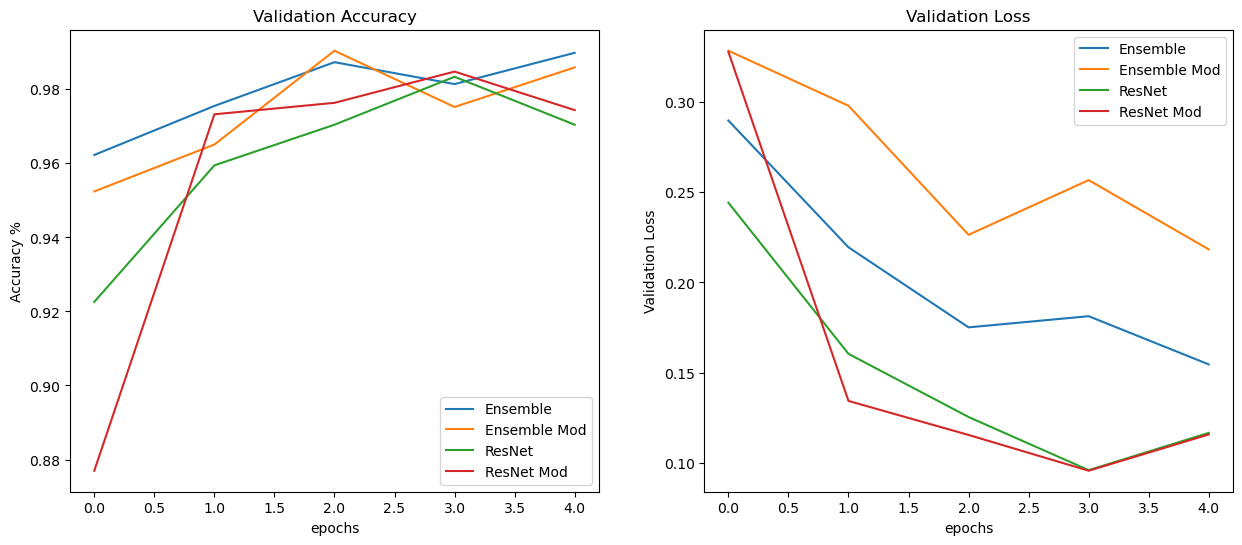

In [36]:
# Compare the Ensembles and ResNets (include the modified versions) accuracy
#Plot as line graph
plt.figure(figsize=(15,6))
plt.plot(accuracies_ens, label='Ensemble CNN')
plt.plot(accuracies_ens_mod, label='Modified Ensemble CNN')
plt.plot(accuracies_res, label='ResNet CNN')
plt.plot(accuracies_res_mod, label='Modified ResNet CNN')
plt.title('Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Based on the results of these models, we can see that based on accuracy alone, the original Ensemble Network mostly maintains the highest accuracy throughout each epoch, and at the end of training, it has the highest accuracy of all the models. However, the original Ensemble Network also has the second highest loss of all the models, which is not ideal. The ResNet Networks have the lowest loss of all the models, but they also generally have the lowest accuracy of all the models. If the total number of epochs was increased, then it is possible that the ResNet Networks would eventually have higher accuracy than the Ensemble Networks, but that is not the case with the current number of epochs.

Accuracy is a good metric for this dataset, but we should also consider another form of evaluation for these models. Let's look at the ROC curves for each model.

111/111 [==============================] - 10s 93ms/step


(0.8, 1.0)

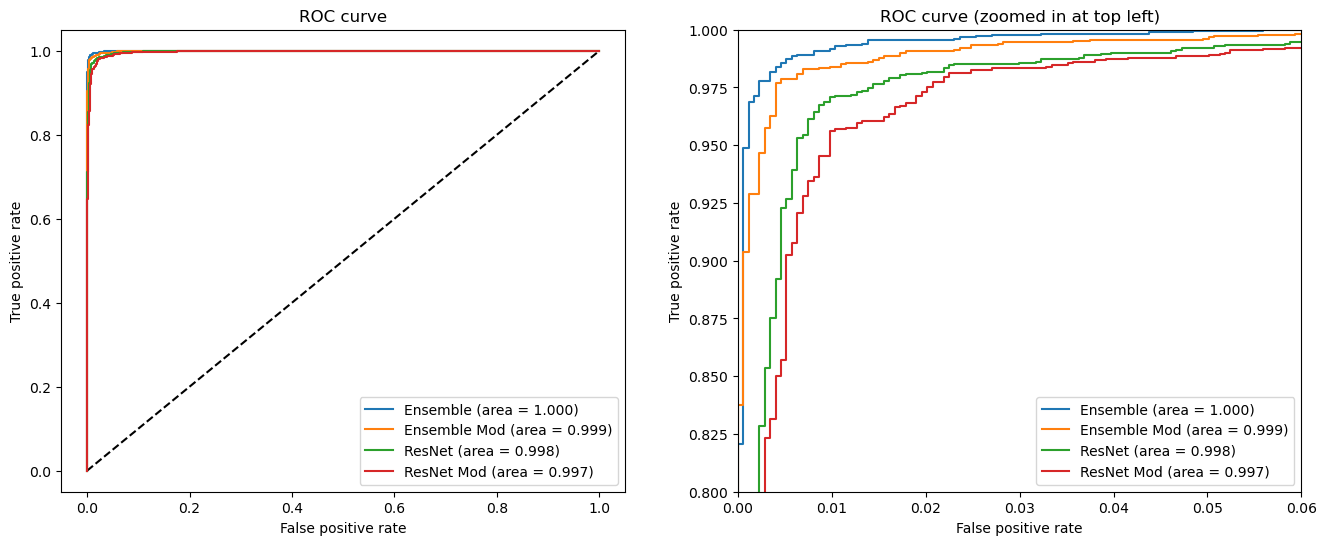

In [35]:
# Compare the 4 models using the receiver operating characteristic (ROC) curve
from sklearn.metrics import roc_curve, auc

# Ensemble Model
y_pred_keras = cnn_ens.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

# Ensemble Model Modified
y_pred_keras_mod = cnn_ens_mod.predict(X_test).ravel()
fpr_keras_mod, tpr_keras_mod, thresholds_keras_mod = roc_curve(y_test, y_pred_keras_mod)
auc_keras_mod = auc(fpr_keras_mod, tpr_keras_mod)

# ResNet Model
y_pred_keras_res = resnet.predict(X_test).ravel()
fpr_keras_res, tpr_keras_res, thresholds_keras_res = roc_curve(y_test, y_pred_keras_res)
auc_keras_res = auc(fpr_keras_res, tpr_keras_res)

# ResNet Model Modified
y_pred_keras_res_mod = resnet_mod.predict(X_test).ravel()
fpr_keras_res_mod, tpr_keras_res_mod, thresholds_keras_res_mod = roc_curve(y_test, y_pred_keras_res_mod)
auc_keras_res_mod = auc(fpr_keras_res_mod, tpr_keras_res_mod)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Ensemble (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_mod, tpr_keras_mod, label='Ensemble Mod (area = {:.3f})'.format(auc_keras_mod))
plt.plot(fpr_keras_res, tpr_keras_res, label='ResNet (area = {:.3f})'.format(auc_keras_res))
plt.plot(fpr_keras_res_mod, tpr_keras_res_mod, label='ResNet Mod (area = {:.3f})'.format(auc_keras_res_mod))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

#Redo the above code but zoom in on the top left corner
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Ensemble (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_mod, tpr_keras_mod, label='Ensemble Mod (area = {:.3f})'.format(auc_keras_mod))
plt.plot(fpr_keras_res, tpr_keras_res, label='ResNet (area = {:.3f})'.format(auc_keras_res))
plt.plot(fpr_keras_res_mod, tpr_keras_res_mod, label='ResNet Mod (area = {:.3f})'.format(auc_keras_res_mod))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.xlim(0, 0.06)
plt.ylim(0.8, 1)

The above plots show the ROC curve, with the right plot showing a zoomed in version to better show the differences between the models. The Ensemble Networks have the highest AUC of all the models, with the original Ensemble Network having the highest AUC of all the models. The Ensemble Network has an AUC value of 1.000, which is the highest possible value, meaning that technically this model is the best classifier. However, an AUC value of 1 can be a sign of overfitting, so we should consider the other models as well. **MORE EXPLANATION HERE**

### 2.4 Convolutional Network vs. Multi-Layer Perceptron

Now that we've created a few different CNN's, let's compare the best one to a standard MLP. First lets create this MLP and then compare the two models.

In [38]:
# Create a basic multi-layer perceptron model
from tensorflow.keras.layers import Activation

mlp = Sequential()
mlp.add(Flatten(input_shape=(img_wh,img_wh,3)))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(1))
mlp.add(Activation('sigmoid'))

mlp.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

mlp_history = mlp.fit(X_train, y_train, batch_size=32,
                      steps_per_epoch=int(len(X_train)/128),
                      epochs=5, verbose=0,
                      validation_data=(X_test,y_test),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                      )

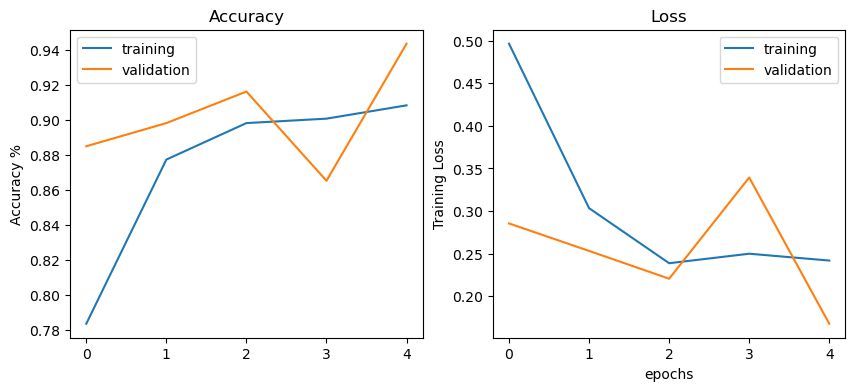

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(mlp_history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(mlp_history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp_history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(mlp_history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

Based on the MLP's performance alone, it is clear that it is not able to attain the same level of accuracy as the CNN's, but lets proceed with the comparison anyway.
Now lets compare the MLP and the Ensemble CNN by plotting their receiver operating characteristic (ROC) curves and calculating their area under the curve (AUC) values.

111/111 [==============================] - 2s 22ms/step


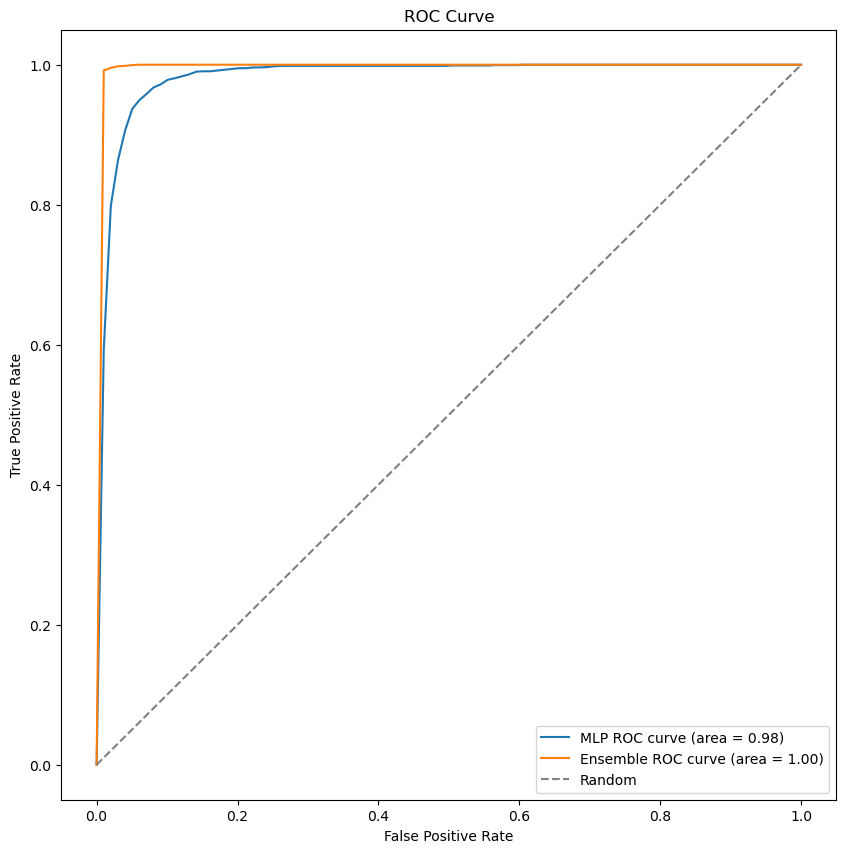

In [42]:
# Compare the Ensemble model to the MLP model using receiver operating characteristic (ROC) curves

from sklearn.metrics import roc_curve, auc

mean_fpr = np.linspace(0, 1, 100)

# MLP model
y_pred_mlp = mlp.predict(X_test).ravel()
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)
mean_tpr_mlp = np.interp(mean_fpr, fpr_mlp, tpr_mlp)
mean_tpr_mlp[0] = 0.0
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# ResNet model
y_pred_ens = cnn_ens.predict(X_test).ravel()
fpr_ens, tpr_ens, thresholds_ens = roc_curve(y_test, y_pred_ens)
mean_tpr_ens = np.interp(mean_fpr, fpr_ens, tpr_ens)
mean_tpr_ens[0] = 0.0
roc_auc_ens = auc(fpr_ens, tpr_ens)


# Plot ROC curves
plt.figure(figsize=(10,10))
plt.plot(mean_fpr, mean_tpr_mlp, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)
plt.plot(mean_fpr, mean_tpr_ens, label='Ensemble ROC curve (area = %0.2f)' % roc_auc_ens)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The Ensemble CNN has a higher AUC value than the MLP, meaning that it is a better classifier than the MLP. This is not surprising, as the CNN's were able to achieve higher accuracy than the MLP, so it makes sense that they would also be better classifiers.  **MORE EXPLANATION HERE**

## 3. Transfer Learning
### 3.1 Transfer Learning Model

In [43]:
# from tensorflow.keras.utils import to_categorical
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions

if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False, input_shape=(img_wh,img_wh,3))

x = X_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = res_no_top.predict(x)
predictions.shape

1/1 [==============================] - 1s 643ms/step


(1, 2, 2, 2048)

In [44]:
X_train_up = preprocess_input(X_train)
X_test_up = preprocess_input(X_test)

X_train_res = res_no_top.predict(X_train_up)
X_test_res = res_no_top.predict(X_test_up)
print(X_train_res.shape)

111/111 [==============================] - 18s 160ms/step
(14208, 2, 2, 2048)


In [55]:
from keras.layers import SeparableConv2D
# from tensorflow.keras.layers import BatchNormalization

input_x = Input(shape=X_train_res[0].shape)

# Adding a fully-connected layer
x = Flatten()(input_x)
x = Dense(200, activation='relu', kernel_initializer='he_uniform')(x)

predictions = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

res_transfer = clone_model(model_base)
res_transfer = Model(inputs=input_x, outputs=predictions)
res_transfer.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2, 2, 2048)]      0         
                                                                 
 flatten_22 (Flatten)        (None, 8192)              0         
                                                                 
 dense_52 (Dense)            (None, 200)               1638600   
                                                                 
 dense_53 (Dense)            (None, 1)                 201       
                                                                 
Total params: 1,638,801
Trainable params: 1,638,801
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_train_resnet = y_train[:X_train_res.shape[0]]

res_transfer.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

res_transfer_history = res_transfer.fit(X_train_res, y_train_resnet, batch_size=32,
                                        steps_per_epoch=int(len(X_train_res)/128),
                                        epochs=5, verbose=0,
                                        validation_data=(X_test_res,y_test[:X_test_res.shape[0]]),
                                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                                        )


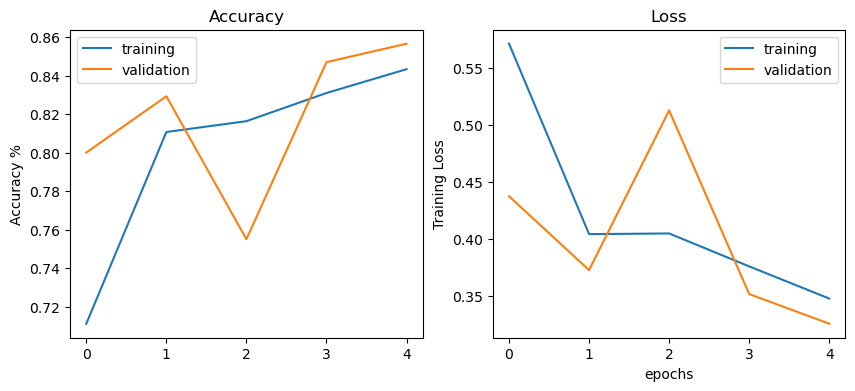

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(res_transfer_history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(res_transfer_history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_transfer_history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(res_transfer_history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

### 3.2 Model Comparison

Now we can compare the classification performance of our transfer learning model to the best CNN we created in the previous section (need to determine). 


**Needs more work, resnet shouldn't have such low accuracy**

ResNet accuracy: 0.508727490901947
Transfer learning accuracy: 0.8567004799842834
111/111 [==============================] - 0s 4ms/step


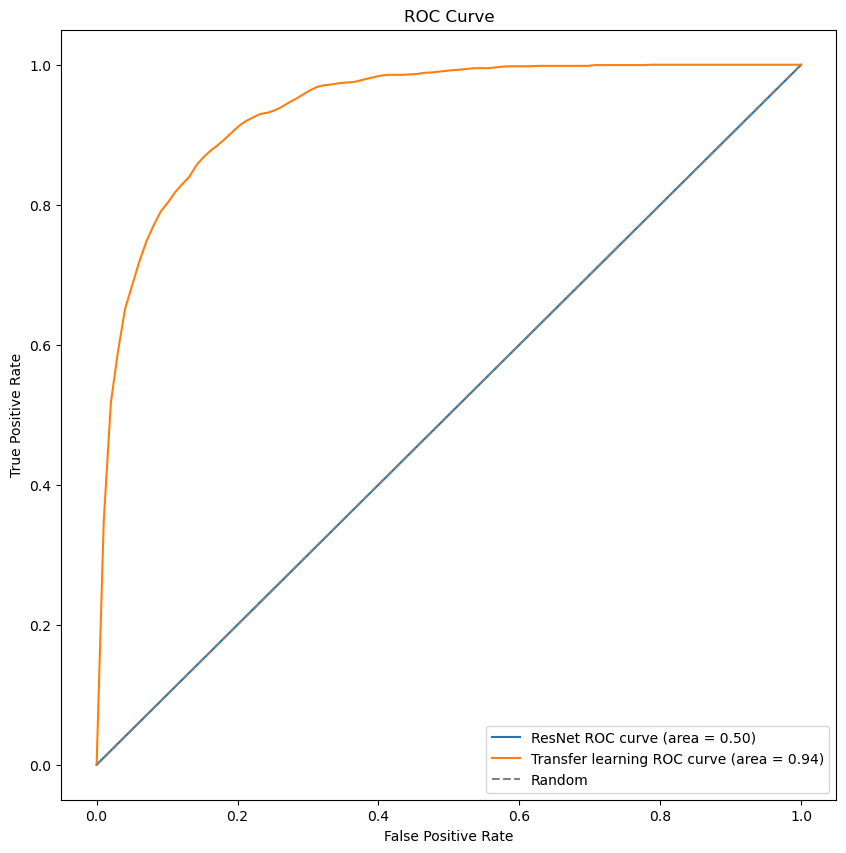

In [54]:
# Compare the ResNet[best] model to the transfer learning model based on classification accuracy

# Get the accuracy scores for each model
score_res = resnet.evaluate(X_test, y_test, verbose=0)
score_res_transfer = res_transfer.evaluate(X_test_res, y_test[:X_test_res.shape[0]], verbose=0)

# Print the accuracy scores
print('ResNet accuracy:', score_res[1])
print('Transfer learning accuracy:', score_res_transfer[1])

# Compare the ResNet[best] model to the transfer learning model using receiver operating characteristic (ROC) curves

mean_fpr = np.linspace(0, 1, 100)

# ResNet model
y_pred_res = resnet.predict(X_test).ravel()
fpr_res, tpr_res, thresholds_res = roc_curve(y_test, y_pred_res)
mean_tpr_res = np.interp(mean_fpr, fpr_res, tpr_res)
mean_tpr_res[0] = 0.0
roc_auc_res = auc(fpr_res, tpr_res)

# Transfer learning model
y_pred_res_transfer = res_transfer.predict(X_test_res).ravel()
fpr_res_transfer, tpr_res_transfer, thresholds_res_transfer = roc_curve(y_test[:X_test_res.shape[0]], y_pred_res_transfer)
mean_tpr_res_transfer = np.interp(mean_fpr, fpr_res_transfer, tpr_res_transfer)
mean_tpr_res_transfer[0] = 0.0
roc_auc_res_transfer = auc(fpr_res_transfer, tpr_res_transfer)

# Plot ROC curves
plt.figure(figsize=(10,10))
plt.plot(mean_fpr, mean_tpr_res, label='ResNet ROC curve (area = %0.2f)' % roc_auc_res)
plt.plot(mean_fpr, mean_tpr_res_transfer, label='Transfer learning ROC curve (area = %0.2f)' % roc_auc_res_transfer)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()